In [1]:
%matplotlib inline
from torch import nn
import torch
import pandas as pd
from d2l import torch as d2l

## Downloading Data

In [2]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

## Reading Data

In [3]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## Data Preprocessing

In [6]:
data.raw_train.iloc[:4, [0,1,2,3,-3,-2,-1]]

Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000

- To start with, we apply a heuristic i.e. we replace all the missing values with the feature's mean
- Also, to put all the features at a common scale, we standardize the data by rescalung the featyres to zero mean and unit variance:
$$x \leftarrow \frac{x - \mu}{\sigma}$$
- For descrete values, we will replace them by one-hot encoding

In [9]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    label = 'SalePrice'
    features = pd.concat((self.raw_train.drop(columns=['Id', label]), self.raw_val.drop(columns=['Id'])))
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std())
    )
    features[numeric_features] = features[numeric_features].fillna(0)
    features = pd.get_dummies(features, dummy_na=True)
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [10]:
data.preprocess()
data.train.shape

(1460, 331)

## Error Measure

- For house prices or maybe stock prices, we care more about relative error than the absolute error i.e. $\frac{y-\hat{y}}{y}$

In [12]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data:
        return
    get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)

    tensors = (get_tensor(data.drop(columns=[label])), torch.log(get_tensor(data[label])).reshape((-1,1)))
    return self.get_tensorloader(tensors, train)
    

In [13]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [14]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

## Model Selection

/Users/divyamchandel/Documents/Projects/neural-networks-practice/env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/divyamchandel/Documents/Projects/neural-networks-practice/env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/divyamchandel/Documents/Projects/neural-networks-practice/env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy developme

average validation log mse = 0.180620079934597


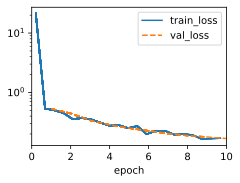

In [15]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [16]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})

In [17]:
submission

Id      SalePrice
0     1461   90218.265625
1     1462  503129.093750
2     1463  197171.000000
3     1464  254476.203125
4     1465  190165.343750
...    ...            ...
1454  2915   73561.140625
1455  2916   89817.773438
1456  2917  244592.906250
1457  2918   91402.359375
1458  2919  210038.453125

[1459 rows x 2 columns]